<a href="https://colab.research.google.com/github/IYashCanCode/Bank-Scheme-Subscribe/blob/main/Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer as CT
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import SelectKBest,f_classif,mutual_info_classif,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_auc_score,roc_curve,RocCurveDisplay
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler,SMOTE
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class Feature_balance:

  def RandomSampler(self):
    sampler = RandomOverSampler(sampling_strategy=0.75)
    return sampler

  def SMOTESample(self):
    sampler = SMOTE(sampling_strategy=0.75)
    return sampler

In [ ]:
class Feature_Engineering:

  def Binary_encoding(self,dataframe):
    self.binary_columns = [ i for i in dataframe.columns if dataframe[i].nunique()==2]

    for i in self.binary_columns:
      dataframe[i].replace({dataframe[i].unique()[0]:0,dataframe[i].unique()[1]:1},inplace=True)

    return dataframe


  def LabelEncoder(self,dataframe):
    for col in dataframe.select_dtypes(include='object').columns:
      lb = LabelEncoder()
      dataframe[col] = lb.fit_transform(dataframe[col])
    return dataframe


  def OneHotEncoder(self,dataframe):
    transformer = CT(transformers=[('ohe',ohe(drop='first',sparse_output=False),list(dataframe.select_dtypes(include='object')))])
    #transformer.fit_transform(dataframe)
    sample = pd.DataFrame(transformer.fit_transform(dataframe))

    start = 0
    renamed_columns = []
    for i in dataframe.select_dtypes(include='object').columns:
      unique = dataframe[i].unique()
      for j in unique[1:]:
        renamed_columns.append(i+'_'+j)
    sample.columns = renamed_columns
    dataframe.drop(list(dataframe.select_dtypes(include='object')),axis=1,inplace=True)
    dataframe = pd.concat([sample,dataframe],axis=1)

    return dataframe

  def Probabiltiy_Ratio(self,dataframe,target):                                                 # Probability_Ration : To encode the categorical feature based on the probability of each column value w.r.t to the target column to the
    for i in dataframe.select_dtypes(include='object').columns:
      if i!=target:
        probability = pd.DataFrame()
        probability['1'] = dataframe.groupby(i)[target].mean()
        probability['0'] = 1-probability['1']
        probability['0'].replace({0.0:0.01},inplace=True)
        probability['P(1)/P(0)'] = probability['1']/probability['0']
        dataframe[i].replace(probability['P(1)/P(0)'].to_dict(),inplace=True)
    return dataframe                                                                            #returns dataframe with encoded values on the probability ration of P(1)/P(0)



In [ ]:
class Feature_Scaling:

    def standard_scaler(self):
        scaler = StandardScaler()
        return scaler


    def min_max_scaler(self):
        scaler = MinMaxScaler()
        return scaler


    def robust_scaler(self):
        scaler = RobustScaler()
        return scaler


In [ ]:
class Feature_Transformation:

  def Logarithmic_Transformation(self,df):
    return np.log1p(df)

  def Sqrt_Transformation(self,df):
    return df

  def Expo_Transformation(self,df):
    return df

  def Reciprocal_Transformation(self,df):
    for i in df.columns:
      df[i].replace({0.0:10.0},inplace=True)
      df[i] = 1/df[i]
    return df

In [ ]:
class Filter_Methods:


  def Univariate_chi2_Selection(self,df,target,k=10):
    df = df.astype('float')

    selector = SelectKBest(score_func=chi2,k=k)
    KbestDf = pd.DataFrame()
    KbestDf['Columns'] = [i for i in df.columns if i!=target]
    KbestDf['Scores'] = selector.fit(df.loc[:,[i for i in df.columns if i!=target]],df.loc[:,target]).scores_
    KbestDf = KbestDf.sort_values(by='Scores',ascending=False).head(k)

    return KbestDf


  def Univariate_fclassif_Selection(self,df,k,target):
    df = df.astype('float')

    selector = SelectKBest(score_func=f_classif,k=k)
    KbestDf = pd.DataFrame()
    KbestDf['Columns'] = [i for i in df.columns if i!=target]
    KbestDf['Scores'] = selector.fit(df.loc[:,[i for i in df.columns if i!=target]],df.loc[:,target]).scores_
    KbestDf = KbestDf.sort_values(by='Scores',ascending=False).head(k)

    return KbestDf


  def Univariate_mutualinfo_Selection(self,df,k,target):
    df = df.astype('float')

    selector = SelectKBest(score_func=mutual_info_classif,k=k)
    KbestDf = pd.DataFrame()
    KbestDf['Columns'] = [i for i in df.columns if i!=target]
    KbestDf['Scores'] = selector.fit(df.loc[:,[i for i in df.columns if i!=target]],df.loc[:,target]).scores_
    KbestDf = KbestDf.sort_values(by='Scores',ascending=False).head(k)

    return KbestDf

class Wrapper_Methods:


  def RFE_LogisticRegression(self,df,target):

    rfe = RFE(LogisticRegression())
    rfe.fit(df.drop(target,axis=1),df[target])
    return rfe.get_feature_names_out()

  def RFE_SVM(self,df,target):

    rfe = RFE(SVC(kernel="linear"))
    rfe.fit(df.drop(target,axis=1),df[target])
    return rfe.get_feature_names_out()



In [ ]:
class dist_plot:

  def hist_plot(self,dataframe,nrows,ncols):
    plt.figure(figsize=(9,10))
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
    plt.subplots_adjust(8,2,16,4)
    numeric_columns = [ i for i in dataframe.select_dtypes(include=['int','float']) if dataframe[i].nunique()>=2]
    for i, ax in zip(range(len(numeric_columns)), axes.ravel()):
        sns.histplot(dataframe[numeric_columns[i]],ax=ax,bins=10,stat='density',kde=True)
    # fig.tight_layout()
    plt.show()


  def qq_plot(self,dataframe,nrows,ncols):
    from statsmodels.graphics.gofplots import qqplot
    plt.figure(figsize=(9,10))
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
    plt.subplots_adjust(8,1,16,2)
    numeric_columns = [ i for i in dataframe.select_dtypes(include=['int','float']).columns if dataframe[i].nunique()>=2]
    for i, ax in zip(range(len(numeric_columns)),axes.ravel()):
        qqplot(dataframe[numeric_columns[i]],ax=ax,line='r')
    # fig.tight_layout()
    plt.show()

In [ ]:
bank_data = pd.read_csv('train.csv')
bank_data.drop('ID',axis=1,inplace=True)

In [ ]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,29,technician,single,tertiary,no,18254,no,no,cellular,11,may,2,-1,0,unknown,no
1,26,services,single,secondary,no,512,yes,yes,unknown,5,jun,3,-1,0,unknown,no
2,30,management,single,secondary,no,135,no,no,cellular,14,aug,2,-1,0,unknown,no
3,41,technician,married,unknown,no,30,yes,no,cellular,10,jul,1,-1,0,unknown,no
4,27,admin.,single,secondary,no,321,no,yes,unknown,2,sep,1,-1,0,unknown,no


In [ ]:
bank_data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
bank_data.describe()

,age,balance,day,campaign,pdays,previous
count,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000
mean,41.091142,1483.774437,15.641103,2.659130,45.555478,0.688967
std,11.305560,3311.055181,8.368983,2.863507,104.449411,2.049696
min,18.000000,-6847.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,102.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,515.000000,16.000000,2.000000,-1.000000,0.000000
75%,49.000000,1591.750000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,43.000000,854.000000,58.000000


In [ ]:
bank_data.duplicated().sum()

0

In [ ]:
encoder = Feature_Engineering()
encoder.Binary_encoding(bank_data)
encoder.LabelEncoder(bank_data)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,29,9,2,2,0,18254,0,0,0,11,8,2,-1,0,3,0
1,26,7,2,1,0,512,1,1,2,5,6,3,-1,0,3,0
2,30,4,2,1,0,135,0,0,0,14,1,2,-1,0,3,0
3,41,9,1,3,0,30,1,0,0,10,5,1,-1,0,3,0
4,27,0,2,1,0,321,0,1,2,2,11,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47,9,1,1,0,1167,1,0,0,30,0,1,87,5,0,1
12866,31,11,1,1,0,111,0,0,0,21,9,2,93,2,0,1
12867,37,10,2,2,0,1316,1,0,0,18,9,1,172,2,0,0
12868,42,4,1,2,0,479,1,0,2,28,8,2,-1,0,3,0


<Figure size 900x1000 with 0 Axes>

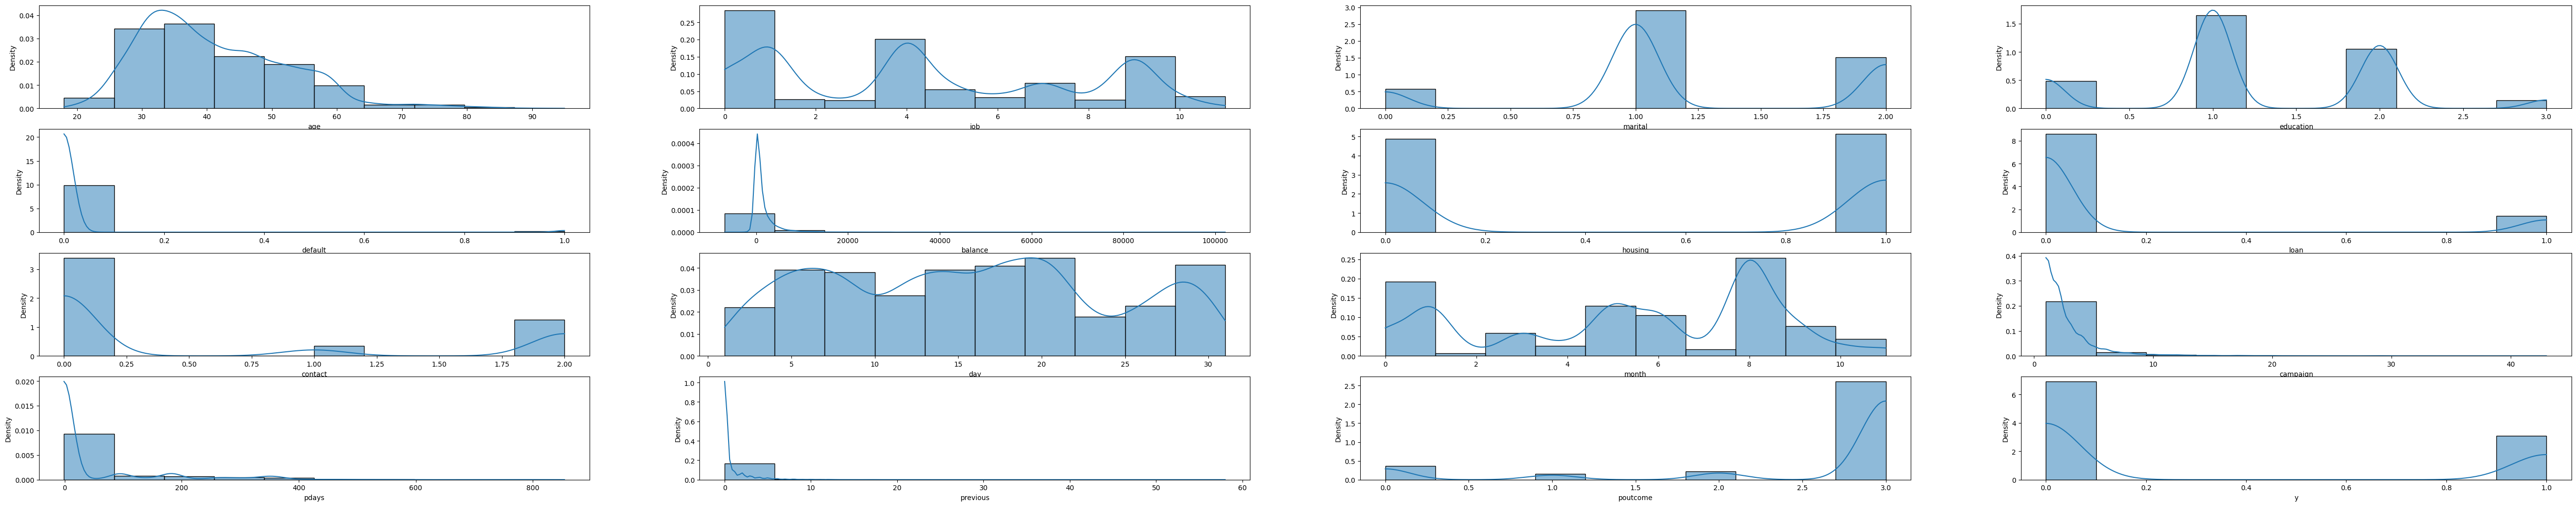

<Figure size 900x1000 with 0 Axes>

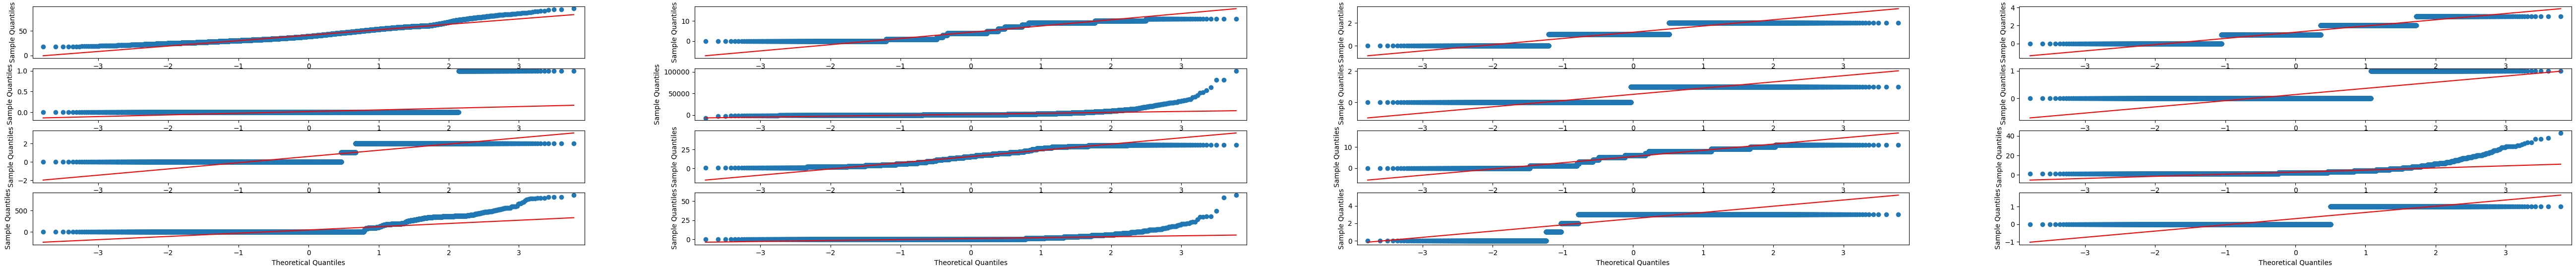

In [ ]:
plot = dist_plot()
plot.hist_plot(bank_data,4,4)
plot.qq_plot(bank_data,4,4)

In [ ]:
# sampler = Feature_balance()
# sampler = sampler.SMOTESample()

In [ ]:
# X_train,Y_train = sampler.fit_resample(X_train,Y_train)

In [ ]:
# (Y_train.value_counts()/Y_train.count()).plot(kind='pie',autopct='%.2f')
# plt.show()

In [ ]:
scaler = Feature_Scaling()

In [ ]:
scaler = scaler.min_max_scaler()

In [ ]:
bank_data = pd.DataFrame(scaler.fit_transform(bank_data))

In [ ]:
bank_data.shape

(12870, 16)

In [ ]:
X = bank_data.iloc[:,:-1]
Y = bank_data.iloc[:,-1]

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9652, 15)
(3218, 15)
(9652,)
(3218,)


In [ ]:
LR_class = LogisticRegression()
LR_class.fit(X_train,Y_train)
LR_Y_pred = LR_class.predict(X_test)

LR_result = pd.DataFrame(np.vstack([Y_test,LR_Y_pred]).T)
LR_result.columns = [['Y_test','Y_pred']]

LR_Probability = LR_class.predict_proba(X_test)

In [ ]:
LR_accuracy = accuracy_score(Y_test,LR_Y_pred)
LR_accuracy

0.7346177750155376

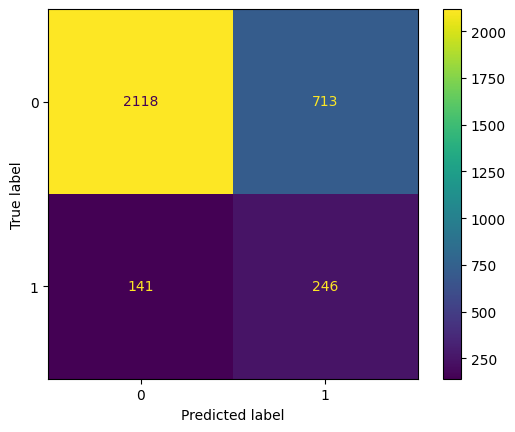

In [ ]:
ConfusionMatrixDisplay(ConfusionMatrixDisplay(confusion_matrix(LR_Y_pred,Y_test)).plot())


In [ ]:
print(classification_report(Y_test,LR_Y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83      2259
         1.0       0.64      0.26      0.37       959

    accuracy                           0.73      3218
   macro avg       0.69      0.60      0.60      3218
weighted avg       0.71      0.73      0.69      3218



In [ ]:
parameters_logistic = {
    'penalty': ['l1', 'l2'],                                                                                  # Regularization penalty ('l1': Lasso, 'l2': Ridge)
    'C': [0.1, 1.0, 10.0],                                                                                    # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],                                                                          # Algorithm to use for optimization
    'fit_intercept': [True, False],                                                                           # Whether to include an intercept term
    'max_iter': [100, 200, 300]                                                                               # Maximum number of iterations
}

LR_class = LogisticRegression()
LR_gridCV = GridSearchCV(LR_class,param_grid=parameters_logistic,cv=5,n_jobs=-1,scoring='accuracy')
LR_gridCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0], 'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
LR_best_params = LR_gridCV.best_params_
LR_best_params

{'C': 10.0,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [ ]:
LR_grid_class = LogisticRegression(**LR_best_params)
LR_grid_class.fit(X_train,Y_train)

LogisticRegression(C=10.0, penalty='l1', solver='saga')

In [ ]:
LR_grid_Y_pred = LR_grid_class.predict(X_test)
LR_grid_accuracy = accuracy_score(Y_test,LR_grid_Y_pred)
LR_grid_accuracy

0.7358607830950901

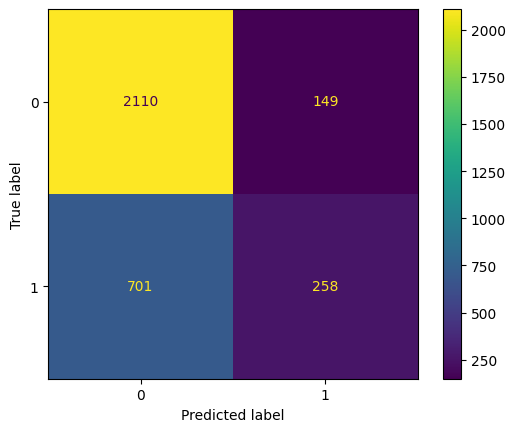

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,LR_grid_Y_pred)).plot()

In [ ]:
print(classification_report(Y_test,LR_grid_Y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83      2259
         1.0       0.63      0.27      0.38       959

    accuracy                           0.74      3218
   macro avg       0.69      0.60      0.61      3218
weighted avg       0.72      0.74      0.70      3218



In [ ]:
DT_class = DecisionTreeClassifier()
DT_class.fit(X_train,Y_train)


DT_Y_pred = DT_class.predict(X_test)
DT_Y_pred_probability = DT_class.predict_proba(X_test)


DT_result = pd.DataFrame(np.vstack([Y_test,DT_Y_pred]).T)
DT_result.columns = [['Y_test','DT_Y_pred']]


DT_accuracy = accuracy_score(Y_test,DT_Y_pred)
DT_accuracy

0.6814791796146675

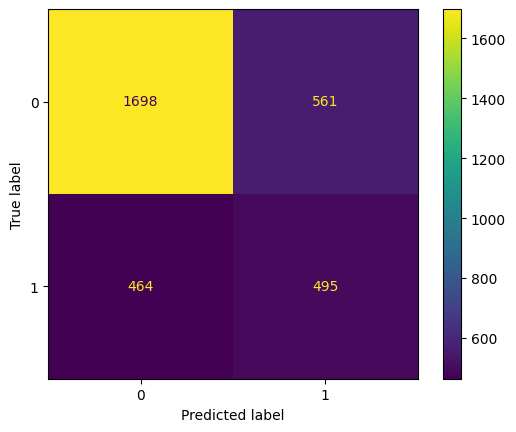

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,DT_Y_pred)).plot()

In [ ]:
print(classification_report(Y_test,DT_Y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      2259
         1.0       0.47      0.52      0.49       959

    accuracy                           0.68      3218
   macro avg       0.63      0.63      0.63      3218
weighted avg       0.69      0.68      0.69      3218



In [ ]:

parameters_dt = {
    'criterion': ['gini', 'entropy'],                                                                               # Criterion for splitting ('gini' or 'entropy')
    'max_depth': [None, 5, 10, 15],                                                                                 # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                                                                                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                                                                                  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']                                                                        # Maximum number of features to consider for splitting
}


DT_class = DecisionTreeClassifier()
DT_gridCV = GridSearchCV(DT_class,param_grid=parameters_dt,cv=5,n_jobs=-1,scoring='accuracy')
DT_gridCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
DT_best_params = DT_gridCV.best_params_
DT_best_params

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [ ]:
DT_grid_class = DecisionTreeClassifier(**DT_best_params)
DT_grid_class.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5)

In [ ]:
DT_grid_Y_pred = DT_grid_class.predict(X_test)
DT_grid_accuracy = accuracy_score(Y_test,DT_grid_Y_pred)

In [ ]:
DT_grid_accuracy

0.7538844002486016

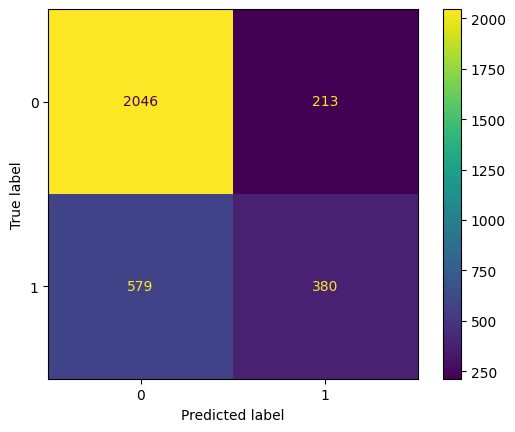

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,DT_grid_Y_pred)).plot()

In [ ]:
print(classification_report(Y_test,DT_grid_Y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      2259
         1.0       0.64      0.40      0.49       959

    accuracy                           0.75      3218
   macro avg       0.71      0.65      0.66      3218
weighted avg       0.74      0.75      0.73      3218



In [ ]:
KNN_class = KNeighborsClassifier()
KNN_class.fit(X_train,Y_train)


KNN_Y_pred = KNN_class.predict(X_test)
KNN_Y_pred_probability = KNN_class.predict_proba(X_test)


KNN_result = pd.DataFrame(np.vstack([Y_test,KNN_Y_pred]).T)
KNN_result.columns = [['Y_test','KNN_Y_pred']]

In [ ]:
KNN_accuracy = accuracy_score(Y_test,KNN_Y_pred)
KNN_accuracy

0.7311995027967682

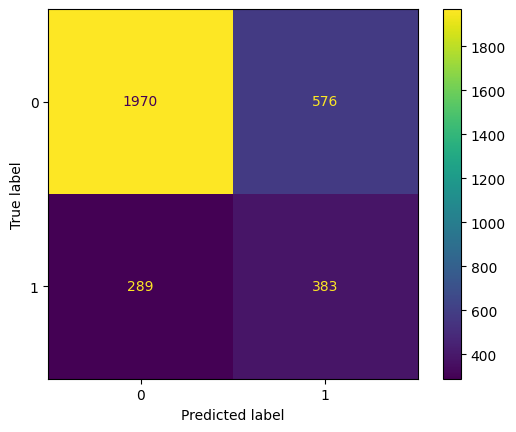

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(KNN_Y_pred,Y_test)).plot()

In [ ]:
print(classification_report(Y_test,KNN_Y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82      2259
         1.0       0.57      0.40      0.47       959

    accuracy                           0.73      3218
   macro avg       0.67      0.64      0.64      3218
weighted avg       0.71      0.73      0.72      3218



In [ ]:
parameters_KNN = {
    'n_neighbors': [3, 5, 7,9,10],                                                                                         # Number of neighbors
    'weights': ['uniform', 'distance'],                                                                                    # Weight function used in prediction
    'p': [1, 2]                                                                                                            # Power parameter for the Minkowski metric
}


KNN_class = KNeighborsClassifier()
KNN_gridCV = GridSearchCV(KNN_class,param_grid=parameters_KNN,cv=5,n_jobs=-1,scoring='accuracy')
KNN_gridCV.fit(X_train,Y_train)


KNN_best_params = KNN_gridCV.best_params_
KNN_best_params

{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


0.7510876320696085

In [ ]:
KNN_class = KNeighborsClassifier(**KNN_best_params)
KNN_class.fit(X_train,Y_train)


KNN_grid_Y_pred = KNN_class.predict(X_test)
KNN_grid_Y_probability = KNN_class.predict_proba(X_test)



KNN_grid_Y_result = pd.DataFrame(np.vstack([Y_test,KNN_grid_Y_pred]).T)
KNN_grid_Y_result.columns = [['Y_test','KNN_grid_Y_pred']]


KNN_grid_accuracy = accuracy_score(Y_test,KNN_grid_Y_pred)
KNN_grid_accuracy

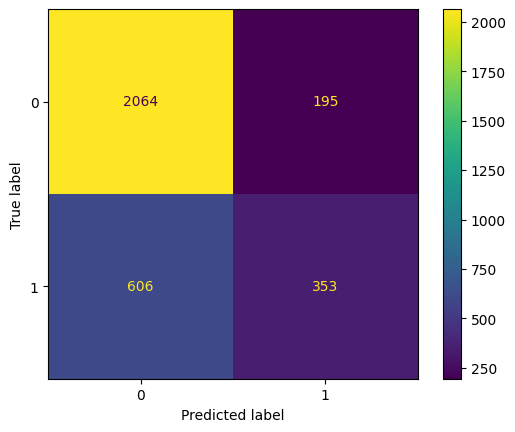

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,KNN_grid_Y_pred)).plot()

In [ ]:
print(classification_report(Y_test,KNN_grid_Y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.91      0.84      2259
         1.0       0.64      0.37      0.47       959

    accuracy                           0.75      3218
   macro avg       0.71      0.64      0.65      3218
weighted avg       0.73      0.75      0.73      3218



In [ ]:
RF_class = RandomForestClassifier()
RF_class.fit(X_train,Y_train)


RF_Y_pred = RF_class.predict(X_test)
RF_Y_pred_probability = RF_class.predict_proba(X_test)


RF_result = pd.DataFrame(np.vstack([Y_test,RF_Y_pred]).T)
RF_result.columns = [['Y_test','RF_Y_pred']]

In [ ]:
RF_accuracy = accuracy_score(Y_test,RF_Y_pred)
RF_accuracy

0.7781230577998757

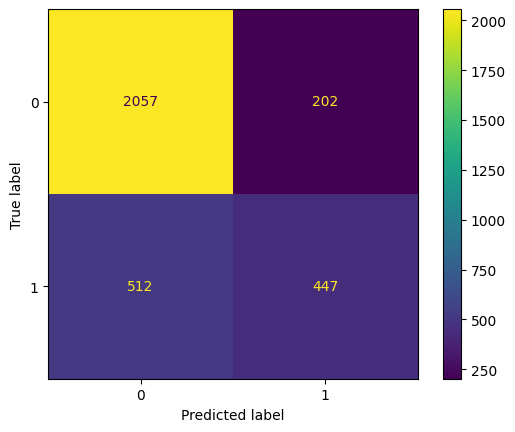

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,RF_Y_pred)).plot()

In [ ]:
print(classification_report(Y_test,RF_Y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85      2259
         1.0       0.69      0.47      0.56       959

    accuracy                           0.78      3218
   macro avg       0.74      0.69      0.70      3218
weighted avg       0.77      0.78      0.76      3218



In [ ]:
SV_class = SVC(probability=True)
SV_class.fit(X_train,Y_train)


SV_Y_pred = SV_class.predict(X_test)
SV_Y_pred_probability = SV_class.predict_proba(X_test)


SV_result = pd.DataFrame(np.vstack([Y_test,SV_Y_pred]).T)
SV_result.columns = [['Y_test','SV_Y_pred']]

In [ ]:
SV_accuracy = accuracy_score(Y_test,SV_Y_pred)
SV_accuracy

0.7467371037911746

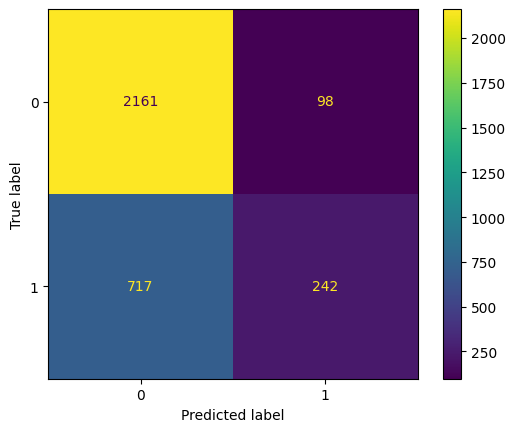

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,SV_Y_pred)).plot()

In [ ]:
print(classification_report(Y_test,SV_Y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84      2259
         1.0       0.71      0.25      0.37       959

    accuracy                           0.75      3218
   macro avg       0.73      0.60      0.61      3218
weighted avg       0.74      0.75      0.70      3218



In [ ]:


parameters_SV = {
    'C': [0.1, 1.0, 10.0],                                                                                    # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],                                                           # Kernel type
    'degree': [2, 3, 4],                                                                                      # Degree of the polynomial kernel function ('poly' kernel)
    'gamma': ['scale', 'auto']                                                                                # Kernel coefficient ('rbf', 'poly', 'sigmoid' kernels)
}


SV_class = SVC()
SV_gridCV = GridSearchCV(SV_class,param_grid=parameters_SV,cv=5,n_jobs=-1,scoring='accuracy')
SV_gridCV.fit(X_train,Y_train)

best_params = SV_gridCV.best_params_
best_params

SV_class = SVC(probaility=True,**best_params)

SV_class.fit(X_train,Y_train)
Y_pred = SV_class.predict(X_test)
Y_pred_probability = SV_class.predict_proba(X_test)
result = pd.DataFrame(np.vstack([Y_test,Y_pred]).T)
result.columns = [['Y_test','Y_pred']]
accuracy_score(Y_test,Y_pred)


TypeError: ignored

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_pred,Y_test)).plot()

In [ ]:
parameters_RF = {
    'n_estimators': [100, 200, 300],                                                                              # Number of trees in the forest
    'criterion': ['gini', 'entropy'],                                                                             # Criterion for splitting ('gini' or 'entropy')
    'max_depth': [None, 5, 10, 15],                                                                               # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                                                                              # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                                                                                # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']                                                                      # Maximum number of features to consider for splitting
}


RF_class = RandomForestClassifier()
RF_gridCV = GridSearchCV(RF_class,param_grid=parameters_RF,cv=5,n_jobs=-1,scoring='accuracy')
RF_gridCV.fit(X_train,Y_train)

RF_best_params = RF_gridCV.best_params_


RF_grid_class = RandomForestClassifier(**RF_best_params)
RF_grid_class.fit(X_train,Y_train)

RF_grid_Y_pred = RF_class.predict(X_test)
RF_grid_Y_pred_probability = RF_class.predict_proba(X_test)


RF_grid_result = pd.DataFrame(np.vstack([Y_test,RF_grid_Y_pred]).T)
RF_grid_result.columns = [['Y_test','RF_grid_Y_pred']]


RF_grid_accuracy = accuracy_score(Y_test,RF_grid_Y_pred)
RF_grid_accuracy


In [ ]:
print(classification_report(Y_pred,Y_test))

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,RF_grid_Y_pred)).plot()

In [ ]:
print(classification_report(Y_test,RF_grid_Y_pred))

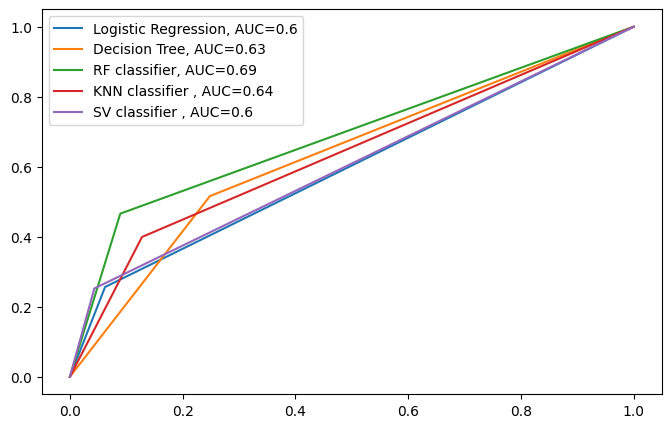

In [ ]:
plt.figure(figsize=(8,5))

fpr,tpr,thresh = roc_curve(Y_test,LR_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(round(roc_auc,2)))


fpr,tpr,thresh = roc_curve(Y_test,DT_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(round(roc_auc,2)))



fpr,tpr,thresh = roc_curve(Y_test,RF_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="RF classifier, AUC="+str(round(roc_auc,2)))


fpr,tpr,thresh = roc_curve(Y_test,KNN_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="KNN classifier , AUC="+str(round(roc_auc,2)))


fpr,tpr,thresh = roc_curve(Y_test,SV_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="SV classifier , AUC="+str(round(roc_auc,2)))


plt.legend()
plt.show()


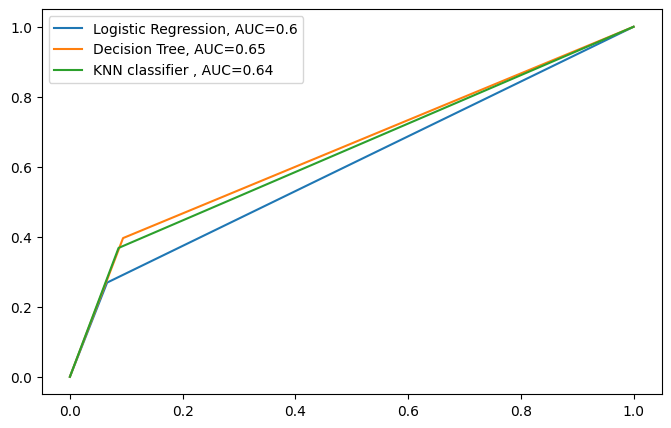

In [ ]:
plt.figure(figsize=(8,5))

fpr,tpr,thresh = roc_curve(Y_test,LR_grid_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(round(roc_auc,2)))


fpr,tpr,thresh = roc_curve(Y_test,DT_grid_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(round(roc_auc,2)))



fpr,tpr,thresh = roc_curve(Y_test,KNN_grid_Y_pred)
roc_auc = metrics.auc(fpr, tpr)
# RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc = roc_auc,estimator_name='example estimator').plot()
plt.plot(fpr,tpr,label="KNN classifier , AUC="+str(round(roc_auc,2)))



plt.legend()
plt.show()
